# Dataset Description

### Stability of the Grid System

*Electrical grids require a balance between electricity supply and demand in order to be stable. Conventional systems achieve this balance through demand-driven electricity production. For future grids with a high share of inflexible (i.e., renewable) energy source, the concept of demand response is a promising solution. This implies changes in electricity consumption in relation to electricity price changes. In this work, we’ll build a binary classification model to predict if a grid is stable or unstable using the UCI Electrical Grid Stability Simulated dataset.*


Dataset: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+

It has 12 primary predictive features and two dependent variables.

**Predictive features:**

- 'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
- 'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
- 'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');

**Dependent variables:**

- 'stab': the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative, linearly stable);
- 'stabf': a categorical (binary) label ('stable' or 'unstable').

Because of the direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' should be dropped and 'stabf' will remain as the sole dependent variable (binary classification).

Split the data into an 80-20 train-test split with a random state of “1”. Use the standard scaler to transform the train set (x_train, y_train) and the test set (x_test). Use scikit learn to train a random forest and extra trees classifier. And use xgboost and lightgbm to train an extreme boosting model and a light gradient boosting model. Use random_state = 1 for training all models and evaluate on the test set.

Also, to improve the Extra Trees Classifier, you will use the following parameters (number of estimators, minimum number of samples, minimum number of samples for leaf node and the number of features to consider when looking for the best split) for the hyperparameter grid needed to run a Randomized Cross Validation Search (RandomizedSearchCV).

n_estimators = [50, 100, 300, 500, 1000]

min_samples_split = [2, 3, 5, 7, 9]

min_samples_leaf = [1, 2, 4, 6, 8]

max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'n_estimators': n_estimators,

'min_samples_leaf': min_samples_leaf,

'min_samples_split': min_samples_split,

'max_features': max_features}


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Data_for_UCI_named.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [3]:
print(data.shape)

data.head()

(10000, 14)


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [4]:
df = data.drop('stab', axis=1)

df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable


In [5]:
# Map Unstable to 0 and Stable to 1
df['stabf'] = df['stabf'].replace({'unstable': 0, 'stable': 1})



In [6]:
df['stabf'].head(10)

0    0
1    1
2    0
3    0
4    0
5    1
6    0
7    0
8    1
9    0
Name: stabf, dtype: int64

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, confusion_matrix
import xgboost as xgb

seed = 1

In [8]:
X = df.drop('stabf', axis=1)
y = df['stabf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

y.value_counts()

0    6380
1    3620
Name: stabf, dtype: int64

In [14]:
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=seed)

X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# len(y_train_bal), len(X_train_bal)
sorted(Counter(y_train_bal).items())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 5092), (1, 5092)]

In [15]:


pipe_rf = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=seed))])
pipe_rf.fit(X_train_bal, y_train_bal)

y_pred_rf = pipe_rf.predict(X_test)
print(pipe_rf.score(X_test, y_test))
cm = confusion_matrix(y_test, y_pred_rf)
cm

0.917


array([[1195,   93],
       [  73,  639]])

In [33]:
pipe_ex = Pipeline([('scaler', StandardScaler()), ('ex', ExtraTreesClassifier(random_state=seed))])
pipe_ex.fit(X_train, y_train)

y_pred_ex = pipe_ex.predict(X_test)
print(pipe_ex.score(X_test, y_test))
cm2 = confusion_matrix(y_test, y_pred_ex)
cm2

0.9285


array([[1257,   31],
       [ 112,  600]])

In [34]:
print(dict(zip(X_train.columns, pipe_ex.named_steps['ex'].feature_importances_)))

{'tau1': 0.11739736493320078, 'tau2': 0.11844468079199041, 'tau3': 0.11316851246674982, 'tau4': 0.11546569217199552, 'p1': 0.039506754233827476, 'p2': 0.04037131556379323, 'p3': 0.040706278296424536, 'p4': 0.040578638540044426, 'g1': 0.08978290601483987, 'g2': 0.09367635844551439, 'g3': 0.09688268324346265, 'g4': 0.09401881529815702}


In [17]:
pipe_xgb = Pipeline([('scaler', StandardScaler()),
                    ('xgb', xgb.XGBClassifier(objective='binary:logistic', seed=seed))])
pipe_xgb.fit(X_train, y_train)

y_pred_xgb = pipe_xgb.predict(X_test)
print(pipe_xgb.score(X_test, y_test))
cm2 = confusion_matrix(y_test, y_pred_xgb)
cm2

0.9195


array([[1236,   52],
       [ 109,  603]])

In [18]:
pipe_xgb = Pipeline([('scaler', StandardScaler()),
                    ('xgb', LGBMClassifier(seed=seed))])
pipe_xgb.fit(X_train, y_train)

y_pred_xgb = pipe_xgb.predict(X_test)
print(pipe_xgb.score(X_test, y_test))
cm2 = confusion_matrix(y_test, y_pred_xgb)
cm2

0.9375


array([[1240,   48],
       [  77,  635]])

In [31]:
n_estimators = [50, 100, 300, 500, 1000]

min_samples_split = [2, 3, 5, 7, 9]

min_samples_leaf = [1, 2, 4, 6, 8]

max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'ex__n_estimators': n_estimators,

                    'ex__min_samples_leaf': min_samples_leaf,

                    'ex__min_samples_split': min_samples_split,

                    'ex__max_features': max_features}
pipe_ex2 = Pipeline([('scaler', StandardScaler()), ('ex', ExtraTreesClassifier(random_state=1))])

random_search = RandomizedSearchCV(estimator=pipe_ex2, param_distributions=hyperparameter_grid, n_iter=10, cv=5, scoring='accuracy', 
                                   verbose=1, n_jobs=-1, random_state=1)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

# y_pred_xgb = pipe_xgb.predict(X_test)
# print(pipe_xgb.score(X_test, y_test))
# cm2 = confusion_matrix(y_test, y_pred_xgb)
# cm2

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


{'ex__n_estimators': 1000, 'ex__min_samples_split': 2, 'ex__min_samples_leaf': 8, 'ex__max_features': None}


In [32]:
print(random_search.best_score_)
print(dict(zip(X_train.columns,random_search.best_estimator_.named_steps['ex'].feature_importances_)))

0.9241249999999999
{'tau1': 0.13723974766109256, 'tau2': 0.14050750384993677, 'tau3': 0.13468028520386593, 'tau4': 0.1354167630909727, 'p1': 0.003683422151688322, 'p2': 0.005336864710946151, 'p3': 0.005429268421191957, 'p4': 0.004962486591192238, 'g1': 0.10256244080927947, 'g2': 0.10757764577478764, 'g3': 0.11306267999167334, 'g4': 0.10954089174337298}


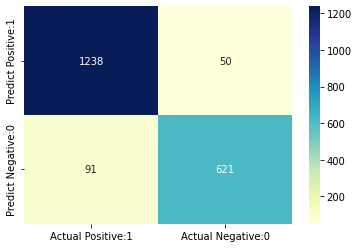

In [12]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')